# VAE MLP MNIST

This notebook is for implementing `Variational Auto-Encoder` with [Tensorflow](https://www.tensorflow.org). <br>
Network architecture will be `Multi-layer perceptron` and [MNIST data](http://yann.lecun.com/exdb/mnist/) will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

## Parameters


In [3]:
img_size   = 28
data_size  = img_size**2

num_label  = 10

batch_size = 512
num_epoch  = 20

n_hidden = 256
n_latent = 128

learning_rate = 1e-3

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

x_train = np.reshape(x_train, [-1, data_size])
x_test  = np.reshape(x_test, [-1, data_size])

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 784)
y_train shape: (60000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


## Encoder

In [6]:
def MLP_encoder(x, keep_prob):
    with tf.variable_scope('MLP_encoder'):
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # First hidden layer
        w1 = tf.get_variable('w1', [x.get_shape()[1], n_hidden], initializer=xavier_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=xavier_init)
        
        h1 = tf.nn.relu(tf.matmul(x,w1)+b1)
        h1 = tf.nn.dropout(h1, keep_prob)
        
        # Second hidden layer
        w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=xavier_init)      
        b2 = tf.get_variable('b2', [n_hidden], initializer=xavier_init)
        
        h2 = tf.nn.relu(tf.matmul(h1,w2)+b2)
        h2 = tf.nn.dropout(h2, keep_prob)
        
        # Output layer
        w_mean = tf.get_variable('w_mean', [h2.get_shape()[1], n_latent], initializer=xavier_init)      
        b_mean = tf.get_variable('b_mean', [n_latent], initializer=xavier_init)      
        
        w_std = tf.get_variable('w_std', [h2.get_shape()[1], n_latent], initializer=xavier_init)      
        b_std = tf.get_variable('b_std', [n_latent], initializer=xavier_init)    
        
        mean = tf.matmul(h2, w_mean)+b_mean
        std  = tf.nn.relu(tf.matmul(h2, w_std)+b_std)
        
        return mean, std

## Decoder

In [7]:
def MLP_decoder(z, keep_prob):
    with tf.variable_scope('MLP_decoder'):
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First hidden layer
        w1 = tf.get_variable('w1', [z.get_shape()[1], n_hidden], initializer=xavier_init)
        b1 = tf.get_variable('b1', [n_hidden], initializer=xavier_init)

        h1 = tf.nn.relu(tf.matmul(z,w1)+b1)
        h1 = tf.nn.dropout(h1, keep_prob)

        # Second hidden layer
        w2 = tf.get_variable('w2', [h1.get_shape()[1], n_hidden], initializer=xavier_init)      
        b2 = tf.get_variable('b2', [n_hidden], initializer=xavier_init)

        h2 = tf.nn.relu(tf.matmul(h1,w2)+b2)
        h2 = tf.nn.dropout(h2, keep_prob)

        # Output layer
        wo = tf.get_variable('wo', [h2.get_shape()[1], data_size], initializer=xavier_init)      
        bo = tf.get_variable('bo', [data_size], initializer=xavier_init)      

        output = tf.sigmoid(tf.matmul(h2, wo)+bo)

        return output

## VAE

In [8]:
def VAE(x, keep_prob_encoder, keep_prob_decoder):
    # Encoder
    mean, std = MLP_encoder(x, keep_prob_encoder)
    
    # Sampling z
    z = mean + std * tf.random_normal(tf.shape(mean), 0, 1, dtype=tf.float32)
    
    # Decoder
    y = MLP_decoder(z, keep_prob_decoder)
    
    # loss
    cross_entropy = - tf.reduce_sum(x * tf.log(1e-8 + y) + (1 - x) * tf.log(1e-8 + 1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(mean) + tf.square(std) - tf.log(1e-8 + tf.square(std)) - 1, 1)
    
    loss = tf.reduce_mean(cross_entropy) + tf.reduce_mean(KL_divergence)
     
    return loss, mean, std, z, y    

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, data_size])
x_normalize = tf.cast(x, tf.float32) / 255.0

keep_prob_encoder = tf.placeholder(tf.float32)
keep_prob_decoder = tf.placeholder(tf.float32)

loss, mean, std, z, y = VAE(x_normalize, keep_prob_encoder, keep_prob_decoder) 

# optimization
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Train

In [11]:
# Training
data_x = x_train
len_data = x_train.shape[0]

for i in range(num_epoch):
    # Shuffle the data 
    np.random.shuffle(data_x)
      
    # Making mini-batch
    for j in range(0, len_data, batch_size):
        if j + batch_size < len_data:
            data_x_in = data_x[j : j + batch_size, :]
        else:
            data_x_in = data_x[j : len_data, :]
        
        # Run Optimizer!
        _, loss_train = sess.run([train_step, loss], feed_dict = {x: data_x_in, keep_prob_encoder: 0.9, keep_prob_decoder: 0.9})

        print("Batch: {} / {}".format(j, len_data), end="\r")
            
    print("Epoch: " + str(i+1) + ' / ' + "Loss: " + str(loss_train))

Epoch: 1 / Loss: 207.12474
Epoch: 2 / Loss: 186.90643
Epoch: 3 / Loss: 170.883
Epoch: 4 / Loss: 156.4654
Epoch: 5 / Loss: 143.96161
Epoch: 6 / Loss: 139.06602
Epoch: 7 / Loss: 135.62518
Epoch: 8 / Loss: 130.91068
Epoch: 9 / Loss: 134.32993
Epoch: 10 / Loss: 132.6017
Epoch: 11 / Loss: 123.47276
Epoch: 12 / Loss: 133.58064
Epoch: 13 / Loss: 125.14267
Epoch: 14 / Loss: 125.77563
Epoch: 15 / Loss: 123.75738
Epoch: 16 / Loss: 130.77655
Epoch: 17 / Loss: 128.16959
Epoch: 18 / Loss: 126.81251
Epoch: 19 / Loss: 128.17857
Epoch: 20 / Loss: 117.04929


## Test (Reconstruction)

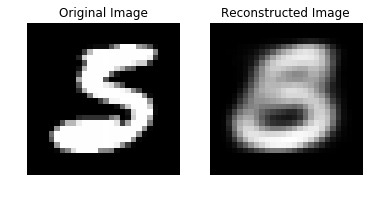

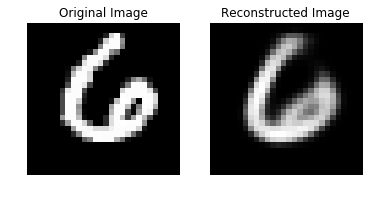

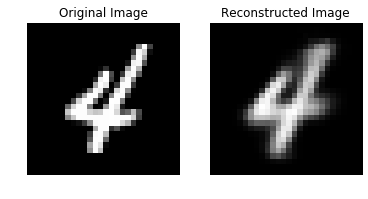

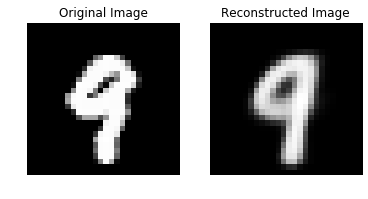

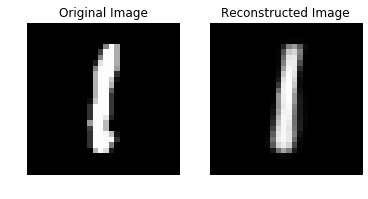

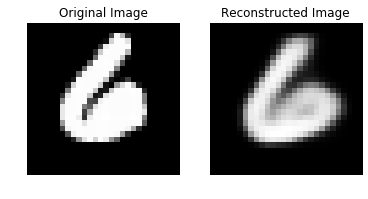

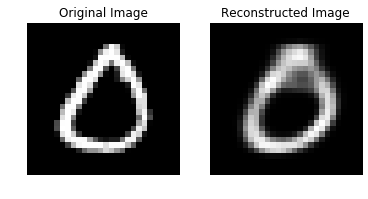

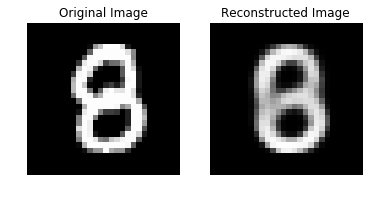

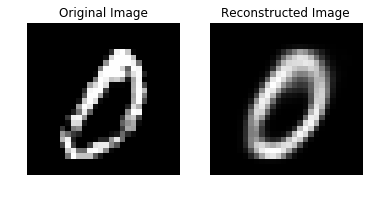

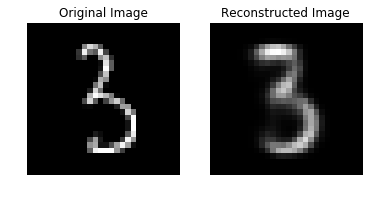

In [12]:
num_test = 10

for i in range(num_test):
    idx = random.randint(0,x_test.shape[0])
    
    output, mu, sigma = sess.run([y, mean, std], feed_dict = {x: [x_test[idx,:]], keep_prob_encoder: 1, keep_prob_decoder: 1})

    input_reshape  = np.reshape(x_test[idx,:], [img_size, img_size])
    output_reshape = np.reshape(output, [img_size, img_size])

    f, ax = plt.subplots(1,2)
    ax[0].imshow(input_reshape, cmap = 'gray')
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    ax[1].imshow(output_reshape, cmap = 'gray')
    ax[1].axis('off')
    ax[1].set_title('Reconstructed Image')

plt.show()

## Print Average mu & sigma

In [13]:
print("Average mu: {}".format(np.mean(mu)))
print("Average std: {}".format(np.mean(sigma)))

Average mu: 0.04700107127428055
Average std: 0.9675211906433105


## Changing Latent Space

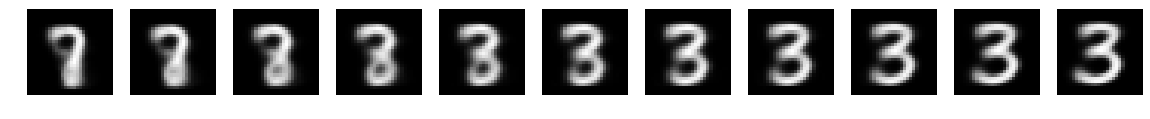

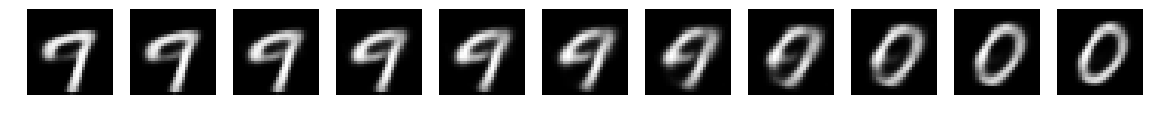

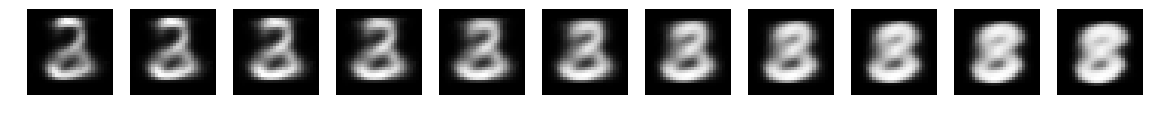

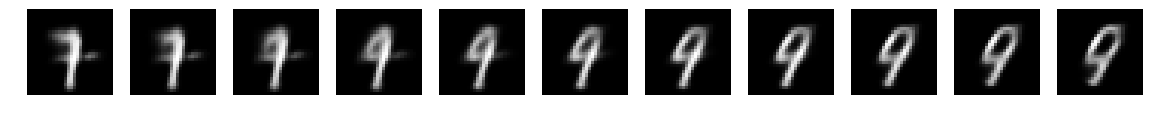

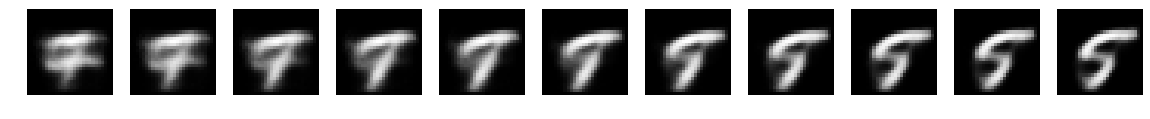

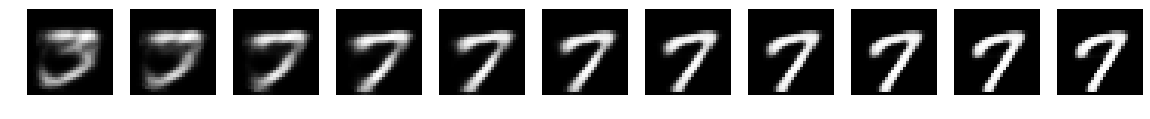

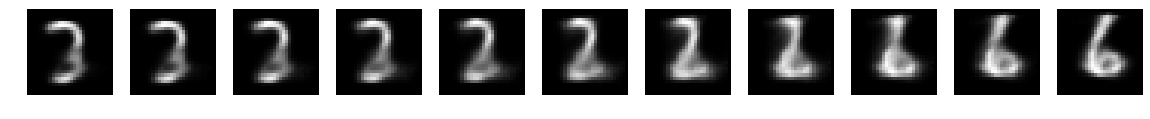

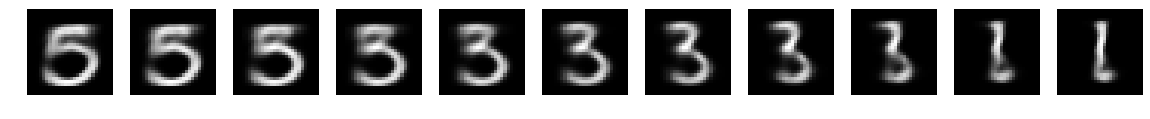

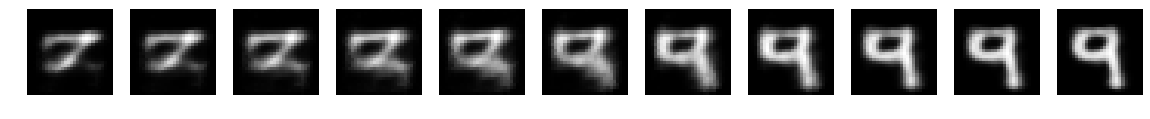

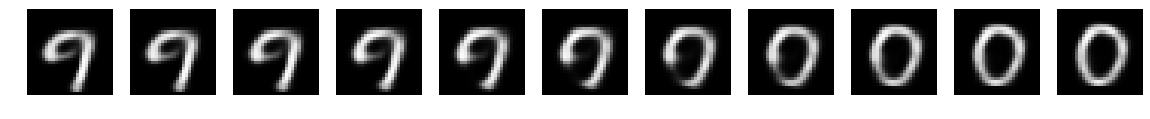

In [14]:
for i in range(num_test):
    z1 = np.random.normal(0, 1, n_latent)
    z2 = np.random.normal(0, 1, n_latent)

    output_list = []

    for j in range(11):
        z_in = (j/10) * z1 + (1 - (j/10)) * z2

        output = sess.run([y], feed_dict = {z: [z_in], keep_prob_decoder: 1})
        output_reshape = np.reshape(output, [img_size, img_size])

        output_list.append(output_reshape)

    f, ax = plt.subplots(1,11,figsize=(20,15))

    for j in range(len(output_list)):
        ax[j].imshow(output_list[j], cmap = 'gray')
        ax[j].axis('off')

    plt.show()